In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.set_printoptions(precision=3, linewidth=500, threshold=500, suppress=True, edgeitems=5)

pd.set_option('display.max_rows', 60)
pd.set_option('display.min_rows', 30)
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', 40)

%load_ext autoreload
%autoreload 2

%matplotlib inline


In [3]:
from ndgsp import GSR, RNC, ProductGraph, MultivariateFilterFunction
from ndgsp.lin_system import solve_SPCGM

from pykronecker import KroneckerDiag, KroneckerIdentity

from scipy.optimize import minimize
from sklearn.cluster import KMeans
import subprocess

from tqdm.auto import tqdm
import time
from itertools import product

In [3]:
Ns = [10, 15, 20]
N = np.prod(Ns)

gamma = 1

np.random.seed(0)

Y = np.random.normal(size=Ns)

S = np.random.randint(2, size=Ns)

Y[~S.astype(bool)] = np.nan

DS = np.diag(S.reshape(-1))

In [4]:
graph = ProductGraph.random_connected(*Ns)
ffunc = MultivariateFilterFunction.diffusion(beta=[0.5, 0.7, 0.6])
ffunc_ = MultivariateFilterFunction.diffusion(beta=[0.5, 0.7, 0.6])
G = ffunc(graph.lams)
# H = graph.U @ np.diag(G.reshape(-1)) @ graph.U.T
# Hi = np.linalg.inv(H)
# cov_true = np.linalg.inv(DS +  gamma * Hi @ Hi)
# var_true = np.diag(cov_true).reshape(*Ns)

# np.log(var_true)


In [10]:
DG = KroneckerDiag(G)

def compute_omega_element(*n):

    sig = np.zeros_like(Y)
    sig[n] = 1

    A_precon = DG @ graph.U.T @ KroneckerDiag(S) @ graph.U @ DG + gamma * KroneckerIdentity(like=DG)
    Phi = graph.U @ DG

    var, nits = solve_SPCGM(A_precon=A_precon, Y=sig, Phi=Phi)

    return np.log(var[n])

compute_omega_element(0, 0, 0)

# To fix  INVALID_ARGUMENT: Executable expected shape ... error, upgrade to latest version of Jax

-5.5883636

In [11]:
Omega = np.array([compute_omega_element(n1, n2, n3) for n1, n2, n3 in tqdm(list(product(*[range(N) for N in Ns])))]).reshape(Y.shape)


  0%|          | 0/3000 [00:00<?, ?it/s]

In [12]:
X1 = np.ones_like(Y)
X2 = (1 - S)
X3 = graph.filter(X2, ffunc)
X4 = (graph.U * graph.U) @ G
X5 = (graph.U * graph.U) @ (G ** 2)
X6 = graph.A @ np.ones_like(Y)
X7 = graph.filter(X6, ffunc)

X = np.array([X1.ravel(), X2.ravel(), X3.ravel(), X4.ravel(), X5.ravel(), X6.ravel(), X7.ravel()]).T


# cluster the features
X_ = X.copy()
X_[:, 1:] = X_[:, 1:] / X_[:, 1:].std(axis=0)
X_[:, 1:] = X_[:, 1:] - X_[:, 1:].mean(axis=0)

n_clusters = 10
clusters = KMeans(n_clusters=n_clusters).fit_predict(X_)

int32
int32


2023-07-21 22:37:13.886635: W external/xla/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:523] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  /usr/local/cuda-12.0
  /usr/local/cuda
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps, setting the environment variable XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda will work.
/home/ed/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [13]:
def bekas():
    
    np.random.seed(0)

    V = 2 * np.random.randint(2, size=(N, N)) - 1

    A_precon = DG @ graph.U.T @ KroneckerDiag(S) @ graph.U @ DG + gamma * KroneckerIdentity(like=DG)

    MVs = np.zeros((N, N))

    for i in tqdm(range(N)):

        MV, nits = solve_SPCGM(A_precon=A_precon, Y=V[:, i], Phi=graph.U @ DG)
        MVs[:, i] = MV

    preds = np.cumsum(MVs * V, axis=1) / np.cumsum(V ** 2, axis=1)

    sq_error = ((preds - np.exp(Omega).ravel()[:, None]) ** 2).sum(0)
    r_sqrd =  1 - sq_error / ((np.exp(Omega) - np.exp(Omega).mean()) ** 2).sum()

    return preds, sq_error, r_sqrd
    


In [14]:
preds_bekas, sq_error_bekas, r_sqrd_bekas = bekas()

  0%|          | 0/3000 [00:00<?, ?it/s]

In [15]:
def get_Omega_Q_random(Q: int, seed=1):
    """
    Get Omega_Q tensor with Q non-missing values picked at random. The rest nan
    """

    np.random.seed(seed)

    S = np.array([True] * Q + [False] * (np.prod(Ns) - Q))
    np.random.shuffle(S)
    S = S.reshape(*Ns)

    Omega_Q = np.zeros_like(Omega)
    Omega_Q[:] = np.nan
    Omega_Q[S] = Omega[S]

    return Omega_Q


def get_Omega_Q_active(Q: int, seed: int=1):
    """
    Get Omega_Q tensor with Q non-missing values picked by cycling 
    though feature clusters. The rest nan.
    """


    np.random.seed(seed)

    groups = [np.argwhere(clusters == i).reshape(-1).tolist() for i in range(n_clusters)]

    np.random.shuffle(groups)

    for group in groups:
        np.random.shuffle(group)

    j = 0

    nqs = np.zeros(Q, dtype=int)

    for i in range(Q):

        group = groups[j % n_clusters]

        while len(group) == 0:
            j += 1
            group = groups[j % n_clusters]

        nqs[i] = group.pop()
        j += 1


    S = np.zeros(np.prod(Ns), dtype=bool)

    S[nqs] = True

    S = S.reshape(*Ns)

    Omega_Q = np.zeros_like(Omega)
    Omega_Q[:] = np.nan
    Omega_Q[S] = Omega[S]

    return Omega_Q



In [22]:
class RidgeRegression:

    def __init__(self, Omega_Q, X, lam=1) -> None:
        
        self.Q = (~np.isnan(Omega_Q)).astype(float)
        self.DQ = KroneckerDiag(self.Q)
        self.Omega_Q = np.nan_to_num(Omega_Q, nan=0, copy=True)
        self.X = X
        self.lam = lam

    def solve(self):

        self.beta = np.linalg.solve(self.X.T @ self.DQ @ self.X + self.lam * np.eye(self.X.shape[1]), self.X.T @ self.Omega_Q.ravel())

        pred = (self.X @ self.beta).reshape(self.Omega_Q.shape)
        pred[self.Q.astype(bool)] = self.Omega_Q[self.Q.astype(bool)]

        return pred


class LFP:

    def __init__(self, Omega_Q, X, lam, graph, ffunc) -> None:
        
        self.Q = (~np.isnan(Omega_Q)).astype(float)
        self.Omega_Q = np.nan_to_num(Omega_Q, nan=0, copy=True)
        self.X = X.copy()
        self.lam = lam
        self.graph = graph
        self.ffunc = ffunc


        if hasattr(ffunc.beta, '__len__'):
            self.beta_len = len(ffunc.beta)
            self.w0 = np.zeros(7 + 2 * self.beta_len)
            self.w0[7:7+self.beta_len] = np.log(ffunc.beta)
            self.w0[7+self.beta_len:] = np.log(ffunc.beta)
        else:
            self.beta_len = 1
            self.w0 = np.zeros(5)
            self.w0[7:] = ffunc.beta


    def predict(self, w):
        
        if self.beta_len == 1:
            beta1, beta2 = np.exp(w[7:])

        else:
            beta1 = np.exp(w[7:7+self.beta_len])
            beta2 = np.exp(w[7+self.beta_len:])
        
        self.ffunc.set_beta(beta1)

        self.X[:, 2] = self.graph.filter(self.X[:, 1], self.ffunc)

        self.ffunc.set_beta(beta2)

        self.X[:, 6] = self.graph.filter(self.X[:, 5], self.ffunc)
        
        return (self.X @ w[:7]).reshape(self.Omega_Q.shape)
    

    def loss(self, w):

        pred = self.predict(w)

        l =  float(((self.Omega_Q - self.Q * pred) ** 2).sum() + self.lam * ((w - self.w0) ** 2).sum())

        print(f'params: {w}, loss: {l:.4e}', end='\r')

        return l
    

    def solve(self, x0: np.ndarray=None):

        if x0 is None:
            x0 = np.zeros(7 + 2 * self.beta_len) 

        sol = minimize(self.loss, x0=x0, method='Nelder-Mead', options={'maxiter': 10000})

        pred = np.array(self.predict(sol.x))

        pred[self.Q.astype(bool)] = self.Omega_Q[self.Q.astype(bool)]

        return pred
    


class GSRVar:

    def __init__(self, Omega_Q, graph, ffunc, gamma) -> None:
        
        self.gsr = GSR(Omega_Q, graph, ffunc, gamma=gamma)
        self.Omega_Q = np.nan_to_num(Omega_Q, nan=0, copy=True)
        self.Q = (~np.isnan(Omega_Q)).astype(float)

    def solve(self):

        pred = np.array(self.gsr.solve())

        pred[self.Q.astype(bool)] = self.Omega_Q[self.Q.astype(bool)]

        return pred
    

class RNCVar:

    def __init__(self, X, Omega_Q, graph, ffunc, gamma=1e-1, lam=1e-5) -> None:

        self.rnc = RNC(X.reshape(*Omega_Q.shape, -1), Omega_Q, graph, ffunc, gamma=gamma, lam=lam)
        self.Omega_Q = np.nan_to_num(Omega_Q, nan=0, copy=True)
        self.Q = (~np.isnan(Omega_Q)).astype(float)

    def solve(self):

        pred = np.array(self.rnc.solve())
        pred[self.Q.astype(bool)] = self.Omega_Q[self.Q.astype(bool)]

        return pred


In [17]:



def square_error(pred: np.ndarray):
    return ((np.exp(Omega) - np.exp(pred)) ** 2).sum() 


def r_squared(pred: np.ndarray):
    return 1 - square_error(pred) / ((np.exp(Omega) - np.exp(Omega).mean()) ** 2).sum() 

In [52]:
def get_error(how: str='passive', seed: int=0):
    """
    Get the square_error and r_squared for each model using passive or active learning
    """

    sq_err = {'RR': [], 'GSR': [],  'RNC': [], 'LFP': []}
    r_sqrd = {'RR': [], 'GSR': [],  'RNC': [], 'LFP': []}

    Qs = (np.logspace(-2, 0) * np.prod(Ns)).astype(int)

    for NQ in tqdm(Qs):

        if how == 'passive':
            Omega_Q = get_Omega_Q_random(NQ, seed=seed)

        elif how == 'active':
            Omega_Q = get_Omega_Q_active(NQ, seed=seed)

        else:
            raise ValueError

        mods = {'RR': RidgeRegression(Omega_Q, X, lam=1e-5),
                'GSR': GSRVar(Omega_Q, graph, ffunc, gamma=1e-1), 
                'RNC': RNCVar(X, Omega_Q, graph, ffunc, gamma=1e-1, lam=1e-5),
                'LFP': LFP(Omega_Q, X, 1e-5, graph, ffunc_)}
        
        preds = {'Input': Omega_Q, 
                'Ground Truth': Omega, 
                'RR': mods['RR'].solve(),
                'GSR': mods['GSR'].solve(), 
                'RNC': mods['RNC'].solve(),
                'LFP': mods['LFP'].solve(mods['RR'].beta.tolist() + np.log(ffunc.beta.tolist() * 2).tolist())}
        
        for name in sq_err.keys():

            sq_err[name].append(square_error(preds[name]))
            r_sqrd[name].append(r_squared(preds[name]))

    return Qs, sq_err, r_sqrd

In [60]:
Qs, sq_err_passive, r_sqrd_passive = get_error('passive', 2)

  0%|          | 0/50 [00:00<?, ?it/s]

In [61]:
Qs, sq_err_active, r_sqrd_active = get_error('active', 2)

  0%|          | 0/50 [00:00<?, ?it/s]

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `VarSolvers.pdf'.


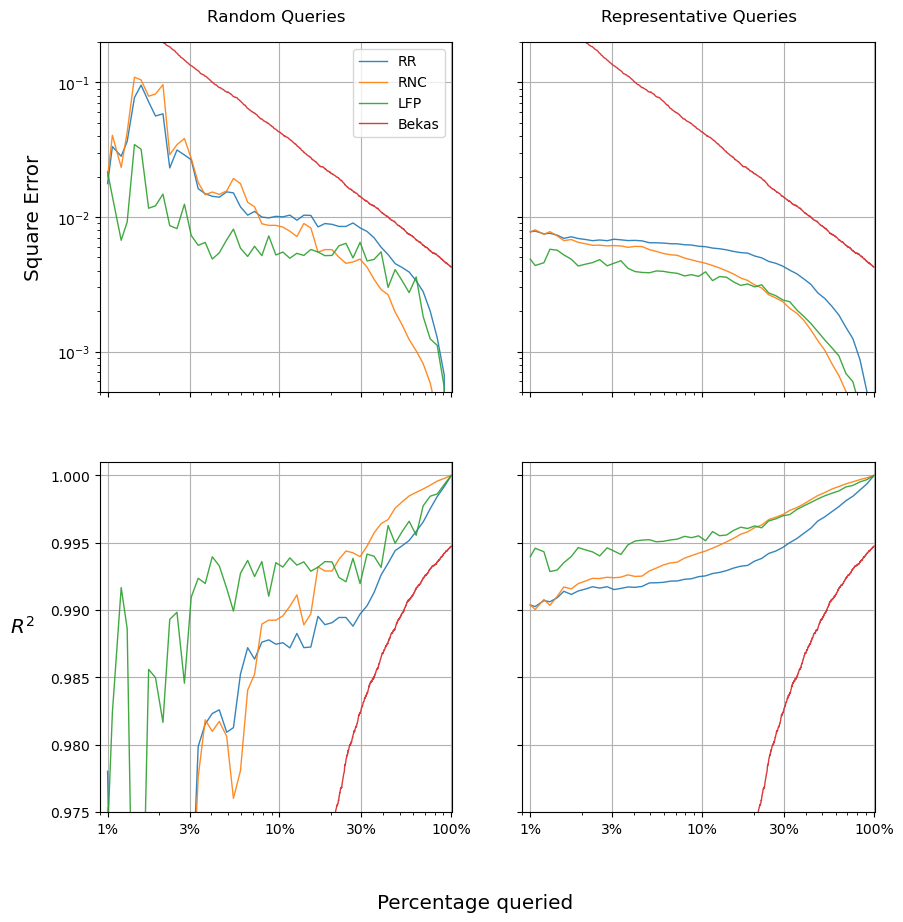

In [67]:
def plot_performance(Qs, sq_err_passive, r_sqrd_passive, sq_err_active, r_sqrd_active, sq_error_bekas, r_sqrd_bekas):
    
    fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True,  sharey='row', figsize=(10, 10))

    for name in r_sqrd_passive.keys():

        if name == 'GSR':

            continue

        axes[0, 0].plot(100 * Qs / N, sq_err_passive[name], label=name, alpha=0.9, lw=1)
        axes[1, 0].plot(100 * Qs / N, r_sqrd_passive[name], label=name, alpha=0.9, lw=1)
        

        axes[0, 1].plot(100 * Qs / N, sq_err_active[name], label=name, alpha=0.9, lw=1)
        axes[1, 1].plot(100 * Qs / N, r_sqrd_active[name], label=name, alpha=0.9, lw=1)
        
    axes[0, 0].plot(100 * np.arange(1, N+1) / N, sq_error_bekas, label='Bekas', alpha=0.9, lw=1)
    axes[0, 1].plot(100 * np.arange(1, N+1) / N, sq_error_bekas, label='Bekas', alpha=0.9, lw=1)
    axes[1, 0].plot(100 * np.arange(1, N+1) / N, r_sqrd_bekas, label='Bekas', alpha=0.9, lw=1)
    axes[1, 1].plot(100 * np.arange(1, N+1) / N, r_sqrd_bekas, label='Bekas', alpha=0.9, lw=1)

    for ax in axes.flatten():

        ax.set_xscale('log')
        

        
        ax.set_xlim(0.9, 101)

        ax.grid()

        ax.set_xticks([1, 3, 10, 30, 100])
        # ax.set_yticks([0.97, 0.98, 0.99, 1])

        ax.xaxis.set_major_formatter(lambda x, pos: str(x) + '%')

    axes[0, 0].set_ylim(5e-4, 0.2e0)
    axes[1, 0].set_ylim(0.975, 1.001)

    axes[0, 0].set_yscale('log')

    axes[0, 0].set_ylabel('Square Error', rotation=90, fontsize='x-large', labelpad=10)
    axes[1, 0].set_ylabel('$R^2$', rotation=0, fontsize='x-large', labelpad=20)

    fig.supxlabel('Percentage queried',  fontsize='x-large')

    axes[0, 0].set_title('Random Queries', pad=15)
    axes[0, 1].set_title('Representative Queries', pad=15)

    axes[0, 0].legend()

    plt.savefig('VarSolvers.pdf')

    subprocess.run(['pdfcrop', 'VarSolvers.pdf', 'VarSolvers.pdf'])


plot_performance(Qs, sq_err_passive, r_sqrd_passive, sq_err_active, r_sqrd_active, sq_error_bekas, r_sqrd_bekas)

In [171]:
from ndgsp import Graph, ProductGraph, MultivariateFilterFunction
from scipy.integrate import quad
from pykronecker import KroneckerProduct, KroneckerSum

In [173]:
def g(x):
    return np.exp(-0.1*x)

def h(x):
    return g(x) ** 2 / (g(x) ** 2 + 1)

np.random.seed(0)

graph = ProductGraph.random_connected(10, 10)

y = np.random.normal(size=(10, 10))



K = 4

fil = MultivariateFilterFunction.diffusion([0.5, 0.8])


lmax = (0.5 * graph.lams[0] + 0.8 * graph.lams[1])[-1, -1]

LL = KroneckerSum([0.5 * graph.L.As[0], 0.8 * graph.L.As[1]])


In [166]:
def c(k):
    if k == 0:
        return 1 / np.pi * quad(lambda theta: h(lmax / 2 * (np.cos(theta) + 1)), 0, np.pi)[0]
    else:
        return 2 / np.pi * quad(lambda theta: np.cos(k * theta) * h(lmax / 2 * (np.cos(theta) + 1)), 0, np.pi)[0] 


def T(lam, k):
    
    if k == 0:
        return np.ones_like(lam)
    
    elif k == 1:
        return 2 * lam / lmax - 1
    
    return (4 * lam / lmax - 2) * T(lam, k-1) - T(lam, k-2)


def T_(k):

    if k == 0:
        return y
    
    elif k == 1:
        return 2 * LL @ y / lmax - y
    
    else:

        return (4 * LL / lmax - 2 * KroneckerIdentity(like=LL)) @ T_(k-1) - T_(k-2)
    

def T__(k):

    if k == 0:
        return KroneckerIdentity(like=LL)
    
    elif k == 1:
        return 2 * lmax ** -1 * LL - T__(0)
    
    return (4 * lmax ** -1 * LL - 2 * T__(0)) @ T__(k-1) - T__(k-2)

In [167]:
graph.U @ KroneckerDiag(h(0.5 * graph.lams[0] + 0.8 * graph.lams[1])) @ graph.U.T @ y

Array([[-0.383, -0.64 , -0.161, -0.034,  0.428,  0.444, -0.26 , -0.125, -0.354, -0.564],
       [-0.554,  0.616, -0.232, -0.257, -0.427,  0.338, -0.64 , -0.089, -0.42 ,  0.092],
       [-0.252, -0.473, -0.081,  0.125,  0.057,  0.082, -0.2  , -0.123, -0.239, -0.182],
       [-0.358, -0.599,  0.026, -0.126, -0.564,  0.108, -0.323,  0.051,  0.298, -0.075],
       [ 0.315, -0.508,  0.238, -0.221, -0.374, -0.315, -0.085,  0.068, -0.542,  0.41 ],
       [ 0.157, -0.548,  0.611,  0.578,  0.427, -0.076, -0.276,  0.487, -0.147,  0.495],
       [ 0.101,  0.366,  0.128,  0.293,  0.053,  0.742,  0.01 ,  0.173,  0.731, -0.536],
       [-0.292,  0.284, -0.454,  0.808, -0.206, -0.271,  0.742,  0.59 ,  0.872,  0.459],
       [-0.191,  0.684, -0.096,  0.287,  0.37 ,  0.055,  0.159,  0.392,  0.212, -0.455],
       [ 0.147,  0.632, -0.24 , -0.029, -0.116,  0.813,  0.271,  0.161, -0.295,  0.228]], dtype=float32)

In [174]:
graph.U @ KroneckerDiag(sum(c(kk) * T(0.5 * graph.lams[0] + 0.8 * graph.lams[1], kk) for kk in range(0, K+1))) @ graph.U.T @ y

Array([[-0.383, -0.64 , -0.161, -0.034,  0.428,  0.444, -0.26 , -0.125, -0.354, -0.564],
       [-0.554,  0.616, -0.232, -0.257, -0.427,  0.338, -0.64 , -0.089, -0.42 ,  0.092],
       [-0.252, -0.473, -0.081,  0.125,  0.057,  0.082, -0.2  , -0.123, -0.239, -0.182],
       [-0.358, -0.599,  0.026, -0.126, -0.564,  0.108, -0.323,  0.051,  0.298, -0.075],
       [ 0.315, -0.508,  0.238, -0.221, -0.374, -0.315, -0.085,  0.068, -0.542,  0.41 ],
       [ 0.157, -0.548,  0.611,  0.578,  0.427, -0.076, -0.276,  0.487, -0.147,  0.495],
       [ 0.101,  0.366,  0.128,  0.293,  0.053,  0.742,  0.01 ,  0.173,  0.731, -0.536],
       [-0.292,  0.284, -0.454,  0.808, -0.206, -0.271,  0.742,  0.59 ,  0.872,  0.459],
       [-0.191,  0.684, -0.096,  0.287,  0.37 ,  0.055,  0.159,  0.392,  0.212, -0.455],
       [ 0.147,  0.632, -0.24 , -0.029, -0.116,  0.813,  0.271,  0.161, -0.295,  0.228]], dtype=float32)

In [149]:
from typing import List

class Node:

    def __init__(self, neighbours: List[Node], c: list, y: float=None):
        """
        Initialise a node object by passing a list of neighbour nodes, as well as the signal value at this 
        node, with None representing an unobserved signal value. 
        """

        self.neighbours = neighbours
        self.degree = len(self.neighbours)

        self.y = y
        self.unobserved = y is None
        self.df = 0
        self.f = 0

    def reconstruct(self):
        pass

    def T(self, k: int, i: int):

        if k == 0:
                return self.y if i == 0 else (self.df if self.unobserved else 0)
        
        elif k == 1:
            return 2 * lmax ** -1 * LL - T__(0)
        
        return (4 * lmax ** -1 * LL - 2 * T__(0)) @ T__(k-1) - T__(k-2)
    
    def M_inv(self, i: int):
        pass

    def L(self, i: int):

        if i == 0:
            return self.degree * self.y -  sum(neighbour.y for neighbour in self.neighbours)
    
        else:
            return (self.degree * self.df if self.unobserved else 0) -  sum(neighbour.df if neighbour.unobserved else 0 for neighbour in self.neighbours)

Array([[-0.348, -0.458, -0.14 , -0.051,  0.276,  0.386, -0.277, -0.097, -0.241, -0.467],
       [-0.455,  0.432, -0.185, -0.22 , -0.307,  0.31 , -0.568, -0.063, -0.399,  0.057],
       [-0.257, -0.42 , -0.116,  0.126,  0.065,  0.066, -0.14 , -0.079, -0.173, -0.17 ],
       [-0.316, -0.445,  0.002, -0.071, -0.399,  0.12 , -0.26 ,  0.068,  0.27 , -0.163],
       [ 0.254, -0.486,  0.26 , -0.161, -0.327, -0.31 , -0.077,  0.096, -0.514,  0.405],
       [ 0.119, -0.445,  0.527,  0.427,  0.318, -0.063, -0.228,  0.436, -0.165,  0.449],
       [ 0.059,  0.27 ,  0.084,  0.232,  0.048,  0.667, -0.015,  0.148,  0.573, -0.453],
       [-0.217,  0.208, -0.402,  0.743, -0.194, -0.233,  0.656,  0.524,  0.811,  0.433],
       [-0.149,  0.569, -0.079,  0.245,  0.307,  0.087,  0.108,  0.361,  0.221, -0.417],
       [ 0.146,  0.612, -0.198, -0.004, -0.084,  0.784,  0.244,  0.151, -0.23 ,  0.186]], dtype=float32)